In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/six-machine-oscillations/PWB1 VM 2500.csv


In [3]:
!pip install git+https://github.com/amazon-science/chronos-forecasting.git

  Cloning https://github.com/amazon-science/chronos-forecasting.git to /tmp/pip-req-build-kctm53rq
  Running command git clone --filter=blob:none --quiet https://github.com/amazon-science/chronos-forecasting.git /tmp/pip-req-build-kctm53rq
  Resolved https://github.com/amazon-science/chronos-forecasting.git to commit afd9cfd062b60ca1ba8d7c9daef7dc820489db0a
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for chronos: filename=chronos-1.2.0-py3-none-any.whl size=13875 sha256=1f4913d39bb777ca159b3287e792ede3244684812061e74dd26212beed252fae
  Stored in directory: /tmp/pip-ephem-wheel-cache-gmd56w6n/wheels/bf/c1/65/08857e57345ef1b34ba0edb4791f1b2594943e82f34e93a4ab
Successfully built chronos


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from chronos import ChronosPipeline

pipeline = ChronosPipeline.from_pretrained(
  "amazon/chronos-t5-large",
  device_map="cuda",
  torch_dtype=torch.bfloat16,
)

df = pd.read_csv("/kaggle/input/six-machine-oscillations/PWB1 VM 2500.csv")


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.84G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/142 [00:00<?, ?B/s]

In [5]:
df = pd.read_csv("/kaggle/input/six-machine-oscillations/PWB1 VM 2500.csv")

In [6]:
df.head(2480)

,V1,V2,V3,V4,V5,VP
0,2,-29,-28,-32,-27,0
1,9,17,18,21,27,-2
2,-13,-6,4,8,-1,-8
3,4,-9,-22,-21,-10,-10
4,12,15,22,14,6,6
...,...,...,...,...,...,...
2475,8,-19,-8,-5,-6,-24
2476,-10,4,-11,-13,-5,20
2477,7,10,31,29,15,2
2478,2,8,-6,12,7,-9


In [7]:
start_time = '2023-01-01 00:00:00'
date_range = pd.date_range(start=start_time, periods=len(df), freq='S')

# Add the DateTime column to the DataFrame
df['DateTime'] = date_range

# Reorder columns if necessary
df = df[['DateTime', 'V4']]

/tmp/ipykernel_730/1939445441.py:2: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  date_range = pd.date_range(start=start_time, periods=len(df), freq='S')


In [8]:
df.head()

,DateTime,V4
0,2023-01-01 00:00:00,-32
1,2023-01-01 00:00:01,21
2,2023-01-01 00:00:02,8
3,2023-01-01 00:00:03,-21
4,2023-01-01 00:00:04,14


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


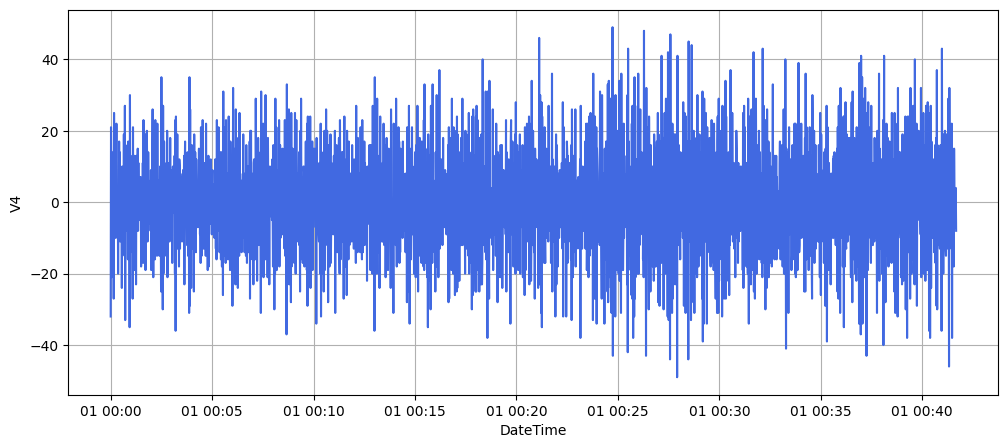

In [9]:
import seaborn as sns
plt.figure(figsize=(12, 5))
sns.lineplot(data=df, x='DateTime', y = 'V4',color='royalblue')
plt.grid();
plt.show();

In [22]:
context = torch.tensor(df["V4"])
prediction_length = 20
forecast = pipeline.predict(context, prediction_length)  # shape [num_series, num_samples, prediction_length]

# visualize the forecast
forecast_index = range(len(df), len(df) + prediction_length)
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)


In [23]:
forecast_index

range(2501, 2521)

In [24]:
np.round(median),np.round(low),np.round(high)

(array([ -1.,   7.,  -0.,  -2.,  -2.,  -0.,  10.,   6., -14.,   7.,   1.,
         -9.,  -1.,   0., -10.,   3., -12.,   2.,   4.,  -1.]),
 array([-11., -11., -10.,  -9., -12., -10.,  -5.,  -8., -25., -17.,  -9.,
        -20., -22., -16., -13., -19., -20., -17., -15., -16.]),
 array([13., 17., 19., 11.,  6., 13., 21., 13.,  6., 27., 25., 12., 27.,
        21., 20., 19., 21., 23., 25., 20.]))

In [31]:
forecast[0][0:1].median()

tensor(-1.2842)

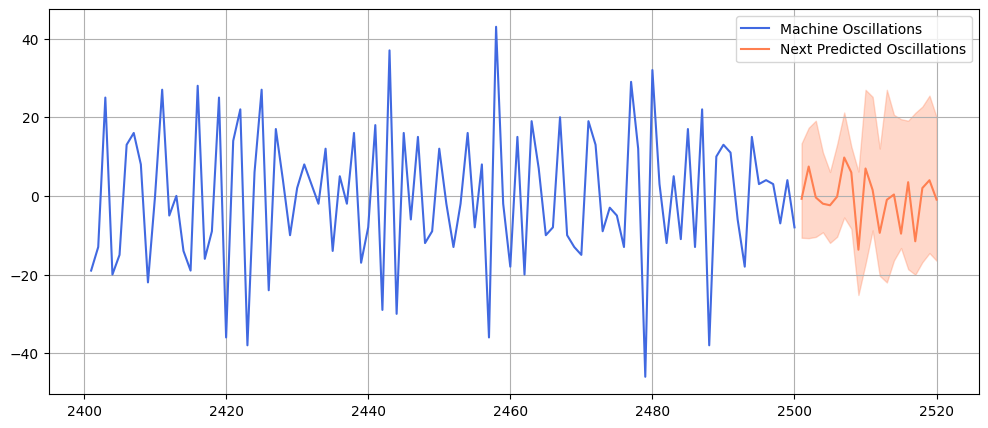

In [26]:
# visualize the results
plt.figure(figsize=(12, 5))
plt.plot(df['V4'].tail(100),color="royalblue", label="Machine Oscillations")
plt.plot(forecast_index, median, color="coral", label="Next Predicted Oscillations")
plt.fill_between(forecast_index, low, high, color="coral", alpha=0.3)
plt.legend()
plt.grid()
plt.show();

In [41]:
df.tail(30)

,DateTime,V2
2471,2023-01-01 00:41:11,26
2472,2023-01-01 00:41:12,-17
2473,2023-01-01 00:41:13,13
2474,2023-01-01 00:41:14,6
2475,2023-01-01 00:41:15,-19
2476,2023-01-01 00:41:16,4
2477,2023-01-01 00:41:17,10
2478,2023-01-01 00:41:18,8
2479,2023-01-01 00:41:19,-27
2480,2023-01-01 00:41:20,9


In [8]:
!pip install autots

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 843.3/843.3 kB 15.3 MB/s eta 0:00:00a 0:00:01


In [ ]:
from autots import AutoTS
model = AutoTS(forecast_length=12, frequency='infer',ensemble='simple')
model = model.fit(df, date_col='DateTime', value_col='V2', id_col=None)
prediction = model.predict()
#make predictions
forecast = prediction.forecast
print("Passengers Forecast")
print(forecast)


Using 1 cpus for n_jobs.
Data frequency is: s, used frequency is: s
Model Number: 1 with model ARIMA in generation 0 of 20
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.75796D+00    |proj g|=  1.51414D-02


 This problem is unconstrained.



At iterate    1    f=  3.75751D+00    |proj g|=  1.65735D-02

At iterate    2    f=  3.75748D+00    |proj g|=  3.86323D-02

At iterate    3    f=  3.75731D+00    |proj g|=  1.60096D-02

At iterate    4    f=  3.75718D+00    |proj g|=  7.11947D-03

At iterate    5    f=  3.75688D+00    |proj g|=  1.72453D-02

At iterate    6    f=  3.75647D+00    |proj g|=  1.95683D-02

At iterate    7    f=  3.75535D+00    |proj g|=  2.10420D-02

At iterate    8    f=  3.75518D+00    |proj g|=  1.48790D-02

At iterate    9    f=  3.75499D+00    |proj g|=  5.68132D-03

At iterate   10    f=  3.75497D+00    |proj g|=  3.34980D-03

At iterate   11    f=  3.75495D+00    |proj g|=  3.02705D-03

At iterate   12    f=  3.75491D+00    |proj g|=  5.58214D-03

At iterate   13    f=  3.75486D+00    |proj g|=  1.13114D-02

At iterate   14    f=  3.75476D+00    |proj g|=  1.85649D-02

At iterate   15    f=  3.75464D+00    |proj g|=  2.07675D-02

At iterate   16    f=  3.75461D+00    |proj g|=  2.53324D-02

At iter

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 8 with model DatepartRegression in generation 0 of 20


2024-06-26 15:12:59.968768: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-26 15:12:59.968891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-26 15:13:00.104513: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.4196
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4206
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4192
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4191
Epoch 5/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4193
Epoch 6/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4189
Epoch 7/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4188
Epoch 8/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4188
Epoch 9/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4187
Epoch 10/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4187
Epoch 11/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4187
Epoch 12/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4188
Epoch 13/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4189
Epoch 14/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4187
Epoch 15/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4186
Epoch 16/50
78/78 ━

/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 31 with model FBProphet in generation 0 of 20


15:13:42 - cmdstanpy - INFO - Chain [1] start processing
15:13:42 - cmdstanpy - INFO - Chain [1] done processing


Model Number: 32 with model MultivariateRegression in generation 0 of 20
Model Number: 33 with model MultivariateRegression in generation 0 of 20
Template Eval Error: ValueError("regression_type='User' but not future_regressor supplied.") in model 33 in generation 0: MultivariateRegression
Model Number: 34 with model DatepartRegression in generation 0 of 20
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 34 in generation 0: DatepartRegression
Model Number: 35 with model SeasonalNaive in generation 0 of 20
Model Number: 36 with model DatepartRegression in generation 0 of 20
Model Number: 37 with model UnobservedComponents in generation 0 of 20
Model Number: 38 with model UnobservedComponents in generation 0 of 20
Model Number: 39 with model ETS in generation 0 of 20
Model Number: 40 with model VECM in generation 0 of 20
Template Eval Error: ValueError('Only gave one variable to VECM') in model 40 in generation 0: VECM
Model Number: 41 wi

/opt/conda/lib/python3.10/site-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/opt/conda/lib/python3.10/site-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 59 in generation 0: Cassandra
Model Number: 60 with model DMD in generation 0 of 20
Model Number: 61 with model DMD in generation 0 of 20
Model Number: 62 with model ConstantNaive in generation 0 of 20
Model Number: 63 with model LastValueNaive in generation 0 of 20
Model Number: 64 with model AverageValueNaive in generation 0 of 20
Model Number: 65 with model GLS in generation 0 of 20
Model Number: 66 with model SeasonalNaive in generation 0 of 20
Model Number: 67 with model GLM in generation 0 of 20
Model Number: 68 with model ETS in generation 0 of 20
Model Number: 69 with model FBProphet in generation 0 of 20
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 69 in generation 0: FBProphet
Model Number: 70 with model UnobservedComponents in generation 0 of 20
Model Number: 71 with model VAR in generation 0 of 20
Template Eval Error: V

/opt/conda/lib/python3.10/site-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/opt/conda/lib/python3.10/site-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Model Number: 86 with model DMD in generation 0 of 20
Model Number: 87 with model RRVAR in generation 0 of 20
Model Number: 88 with model FFT in generation 0 of 20
Template Eval Error: Exception("Transformer AlignLastValue failed on inverse from params ffill {'0': {'method': 'savgol_filter', 'method_args': {'window_length': 31, 'polyorder': 3, 'deriv': 0, 'mode': 'interp'}}, '1': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': 10}, '2': {}, '3': {}, '4': {'window_size': 30, 'alpha': 2.0, 'grouping_forward_limit': 3, 'max_level_shifts': 30, 'alignment': 'average'}, '5': {'rows': 7, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': None}}") in model 88 in generation 0: FFT
Model Number: 89 with model Cassandra in generation 0 of 20
Model Number: 90 with model SeasonalityMotif in generation 0 of 20


/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 91 with model SeasonalityMotif in generation 0 of 20
Model Number: 92 with model AverageValueNaive in generation 0 of 20
Template Eval Error: Exception("Transformer STLFilter failed on fit from params time {'0': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 0.9, 'first_value_only': False, 'threshold': 1}, '1': {'decomp_type': 'STL', 'part': 'trend', 'seasonal': 7}, '2': {'method': 'clip', 'std_threshold': 2, 'fillna': None}}") in model 92 in generation 0: AverageValueNaive
Model Number: 93 with model ConstantNaive in generation 0 of 20
Model Number: 94 with model SectionalMotif in generation 0 of 20
Model Number: 95 with model UnivariateMotif in generation 0 of 20
Model Number: 96 with model SectionalMotif in generation 0 of 20
Model Number: 97 with model NVAR in generation 0 of 20
Model Number: 98 with model VAR in generation 0 of 20
Template Eval Error: ValueError('Only gave one variable to VAR') in model 98 in generation 0: VAR
Model Number: 99 with model VAR

 This problem is unconstrained.



At iterate    8    f=  3.91382D+00    |proj g|=  6.41698D-02

At iterate    9    f=  3.90888D+00    |proj g|=  5.53292D-02

At iterate   10    f=  3.90526D+00    |proj g|=  6.41549D-02

At iterate   11    f=  3.90171D+00    |proj g|=  2.93391D-02

At iterate   12    f=  3.89991D+00    |proj g|=  2.60025D-02

At iterate   13    f=  3.89855D+00    |proj g|=  2.10523D-02

At iterate   14    f=  3.89730D+00    |proj g|=  1.54887D-02

At iterate   15    f=  3.89596D+00    |proj g|=  2.77804D-02

At iterate   16    f=  3.89216D+00    |proj g|=  7.34815D-02

At iterate   17    f=  3.89132D+00    |proj g|=  1.05955D-01

At iterate   18    f=  3.88978D+00    |proj g|=  5.37584D-02

At iterate   19    f=  3.88772D+00    |proj g|=  2.40330D-02

At iterate   20    f=  3.88577D+00    |proj g|=  4.30504D-02

At iterate   21    f=  3.88440D+00    |proj g|=  1.10126D-02

At iterate   22    f=  3.88382D+00    |proj g|=  1.37799D-02

At iterate   23    f=  3.88202D+00    |proj g|=  4.37182D-02

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate  112    f=  3.86638D+00    |proj g|=  2.43979D-03

At iterate  113    f=  3.86638D+00    |proj g|=  2.95277D-03

At iterate  114    f=  3.86638D+00    |proj g|=  5.07818D-03

At iterate  115    f=  3.86638D+00    |proj g|=  7.17817D-03

At iterate  116    f=  3.86638D+00    |proj g|=  9.45208D-03

At iterate  117    f=  3.86638D+00    |proj g|=  1.39894D-02

At iterate  118    f=  3.86637D+00    |proj g|=  1.72152D-02

At iterate  119    f=  3.86636D+00    |proj g|=  2.67287D-02

At iterate  120    f=  3.86634D+00    |proj g|=  2.53296D-02

At iterate  121    f=  3.86631D+00    |proj g|=  5.93961D-02

At iterate  122    f=  3.86627D+00    |proj g|=  3.30327D-02

At iterate  123    f=  3.86619D+00    |proj g|=  3.65856D-02

At iterate  124    f=  3.86616D+00    |proj g|=  4.57390D-02

At iterate  125    f=  3.86604D+00    |proj g|=  9.52986D-02

At iterate  126    f=  3.86598D+00    |proj g|=  3.38350D-02

At iterate  127    f=  3.86594D+00    |proj g|=  2.33183D-02

At iter

/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 136 in generation 0: GLM
Model Number: 137 with model MetricMotif in generation 0 of 20
Model Number: 138 with model Cassandra in generation 0 of 20
Template Eval Error: ValueError('more than 1 year of data is required for holiday detection.') in model 138 in generation 0: Cassandra
Model Number: 139 with model SeasonalityMotif in generation 0 of 20


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.63932e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Model Number: 140 with model SeasonalityMotif in generation 0 of 20
Model Number: 141 with model GLS in generation 0 of 20
Model Number: 142 with model RRVAR in generation 0 of 20
Model Number: 143 with model ConstantNaive in generation 0 of 20
Model Number: 144 with model GLS in generation 0 of 20
Model Number: 145 with model DatepartRegression in generation 0 of 20
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 145 in generation 0: DatepartRegression
Model Number: 146 with model UnobservedComponents in generation 0 of 20
Model Number: 147 with model UnobservedComponents in generation 0 of 20
Model Number: 148 with model ARDL in generation 0 of 20
Template Eval Error: ValueError("regression_type='User' but future_regressor not supplied") in model 148 in generation 0: ARDL
Model Number: 149 with model LastValueNaive in generation 0 of 20
Model Number: 150 with model VAR in generation 0 of 20
Template Eval Error: ValueError('Only gave o

In [1]:
forecast

NameError: name 'forecast' is not defined